In [ ]:
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install geopandas
!pip install descartes --quiet
!pip install osmnx
!pip install folium

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 2s (1,023 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155514 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.13.3-2ub

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import random
import pickle
from numpy.random import default_rng

In [ ]:
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')

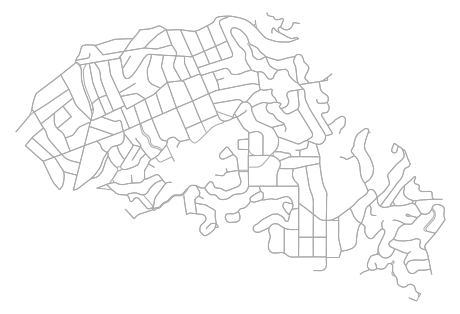

In [ ]:
fig, ax = ox.plot_graph(G, bgcolor='white', node_size=0, edge_color='darkgray')

In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
print(gdf_nodes.shape[0])
print(gdf_edges.shape[0])

348
940


In [ ]:
rng = default_rng()
numbers = rng.choice(gdf_nodes.shape[0], size=41, replace=False)
print(numbers)

[223   9 102 159 222 333 243 165  54 208 131   3 276 180 140  72 149 198
  17 290  52   2 195 327 285 152  39 316 280  66 186 320 340 231  49  75
 250  25 263 341 143]


In [ ]:
delivery_locations = list(np.array(gdf_nodes.iloc[numbers[1:] ,[True, True, False, False, False]]))
origin = np.array(gdf_nodes.iloc[numbers[0] ,[True, True, False, False, False]])
print(origin)
print(delivery_locations)

[37.8259388 -122.242265]
[array([  37.8210912, -122.229516 ]), array([  37.8281394, -122.2439103]), array([  37.8229119, -122.2170751]), array([  37.8200567, -122.2339662]), array([  37.8227966, -122.2364855]), array([  37.823268 , -122.2390841]), array([  37.8278221, -122.2270165]), array([  37.8152545, -122.2252349]), array([  37.8164526, -122.2171603]), array([  37.8219657, -122.2374402]), array([  37.8254055, -122.2453167]), array([  37.8270584, -122.2234677]), array([  37.8255579, -122.2428398]), array([  37.8262467, -122.2328934]), array([  37.8294433, -122.2322968]), array([  37.8169542, -122.2336212]), array([  37.819347 , -122.2337456]), array([  37.8220724, -122.2295143]), array([  37.8139809, -122.2170155]), array([  37.8171025, -122.2252231]), array([  37.8249179, -122.2460801]), array([  37.8254448, -122.2400334]), array([  37.82956  , -122.2293633]), array([  37.8125359, -122.2150145]), array([  37.8152613, -122.2239865]), array([  37.8230529, -122.2364161]), array([  37.

In [ ]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
w = "travel_time"

orig = ox.distance.get_nearest_node(G, tuple(origin))
dest = ox.distance.get_nearest_node(G, tuple(delivery_locations[0]))
route1 = nx.shortest_path(G, orig, dest, weight=w)

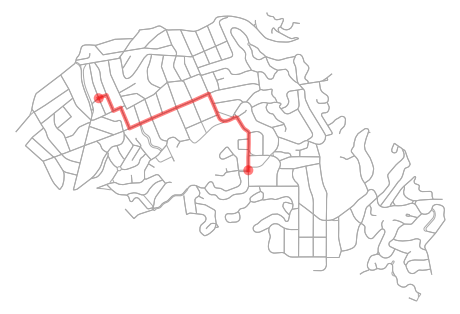

In [ ]:
fig, ax = ox.plot_graph_route(G, route1, bgcolor='white', node_size=0, edge_color='darkgray')

In [ ]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route1, "length")
round(sum(edge_lengths))

1841

In [ ]:
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

1243

[ 0  1  2  0  3  3  4  0  5  3  3  4  3  6  4  0  0  0  7  0  3  3  4  7
  0  3  6  8  9  2  7  2  8  0 10  0  6  0  3  8]


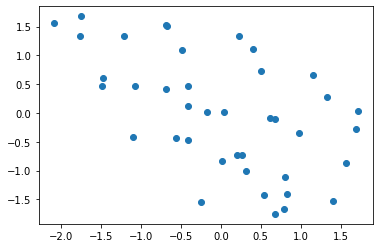

In [ ]:
X = np.array(delivery_locations)
X = StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1])

# Compute DBSCAN
db = DBSCAN(eps=0.55, min_samples=1).fit(X)
print(db.labels_)

In [ ]:
truck_stops = []
for label in range(max(db.labels_+1)):
  x_sum = 0
  y_sum = 0
  count = 0
  for ind in range(len(db.labels_)):
    if db.labels_[ind] == label:
      x_sum += delivery_locations[ind][0]
      y_sum += delivery_locations[ind][1]
      count += 1
  truck_stops.append((x_sum/count,y_sum/count))

print(truck_stops)
print(len(truck_stops))  

[(37.818728954545456, -122.22857559090909), (37.8281394, -122.2439103), (37.82356003333334, -122.21970186666668), (37.824081166666666, -122.2407416888889), (37.828470949999996, -122.22803607499999), (37.8164526, -122.2171603), (37.8252671, -122.23136313333333), (37.8135274, -122.2153028), (37.8191276, -122.2167343), (37.8288915, -122.2377687), (37.8207612, -122.2441099)]
11


## Genetic Algorithm ##

In [ ]:
def crossover(parentx,parenty):

  crossover_point_1 = np.random.randint(0, parentx.shape[0])
  crossover_point_2 = np.random.randint(crossover_point_1, parentx.shape[0])

  childx = np.concatenate((parentx[:crossover_point_1,:], parenty[crossover_point_1:crossover_point_2,:], parentx[crossover_point_2:,:]), axis = 0)
  childy = np.concatenate((parenty[:crossover_point_1,:], parentx[crossover_point_1:crossover_point_2,:], parenty[crossover_point_2:,:]), axis = 0)
  
  return childx, childy

In [ ]:
def mutation(parentx):

  mutation_index_1 = np.random.randint(0, parentx.shape[0] - 1)
  mutation_index_2 = np.random.randint(0, parentx.shape[0] - 1)

  parentx[mutation_index_1, :], parentx[mutation_index_2, :] = parentx[mutation_index_2, :], parentx[mutation_index_1, :]
  
  return parentx

In [ ]:
def shortest_path(x, y):
  orig = ox.distance.get_nearest_node(G, tuple(x))
  dest = ox.distance.get_nearest_node(G, tuple(y))
  route = nx.shortest_path(G, orig, dest, weight=w)
  edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
  dist = round(sum(edge_lengths))
  return dist

In [ ]:
def fitness(origin, route):
  distance_route = shortest_path(origin , route[0,:])
  for i in range(route.shape[0]-1):
    distance_route += shortest_path(route[i,:], route[i+1,:])
  distance_route += shortest_path(route[-1], origin)

  eps = pow(10, -6)

  fitness = (1/(distance_route+eps)) * pow(10, 6)
  
  return fitness

In [ ]:
def populationstart(route):
  indices = list(range(0,route.shape[0]))
  random.shuffle(indices)
  route = route[indices,:]
  return route

In [ ]:
def tournament_selection(population, fitness):
  indices = random.sample(range(0,len(fitness)), 5)
  selection = list(fitness[index] for index in indices)
  best_fitness_index = selection.index(max(selection))
  return population[best_fitness_index]

In [ ]:
def nextgen(starting_point, current_population, fitness, crossover_rate, mutation_rate):

  new_population = current_population

  for i in range(len(current_population)):
    parentx = tournament_selection(current_population, fitness)
    parenty = tournament_selection(current_population, fitness)

    childx, childy = None, None
    if np.random.random_sample() < crossover_rate:
      childx, childy = crossover(parentx,parenty)

    if childx is not None:
      if np.random.random_sample() < mutation_rate:
        childx = mutation(childx)
        
      if np.random.random_sample() < mutation_rate:
        childy = mutation(childy)

      new_population.append(childx)
      new_population.append(childy)       

  return new_population

In [ ]:
def genetic_algorithm(origin, route, population_size, crossover_rate, mutation_rate, number_of_generations):

  route = np.array(route)

  population = []
  best_route = None
  for i in range(population_size):
    population.append(populationstart(route))

  for generation in range(number_of_generations):

    population_fitness = []
    for individual in population:
      population_fitness.append(fitness(origin, individual))
    best_route = population[population_fitness.index(max(population_fitness))]

    ind = np.argpartition(population_fitness, -20)[-20:]
    ind = ind.tolist()
    best_population = []
    for i in ind:
      best_population.append(population[i])
    population = best_population

    population = nextgen(origin, population, population_fitness, crossover_rate, mutation_rate)

  return best_route

In [ ]:
best_route = genetic_algorithm(origin, truck_stops, population_size = 20, crossover_rate = 0.5, mutation_rate = 0.01, number_of_generations = 30)

In [ ]:
print(best_route)

[[  37.81872895 -122.22857559]
 [  37.8191276  -122.2167343 ]
 [  37.8191276  -122.2167343 ]
 [  37.8164526  -122.2171603 ]
 [  37.8191276  -122.2167343 ]
 [  37.8191276  -122.2167343 ]
 [  37.82356003 -122.21970187]
 [  37.8288915  -122.2377687 ]
 [  37.8281394  -122.2439103 ]
 [  37.8281394  -122.2439103 ]
 [  37.8207612  -122.2441099 ]]


In [ ]:
def shortest_route(x, y):
  orig = ox.distance.get_nearest_node(G, tuple(x))
  dest = ox.distance.get_nearest_node(G, tuple(y))
  route = nx.shortest_path(G, orig, dest, weight=w)
  return route

In [ ]:
def display_shortest_route(origin, route):
  routes = []
  routes.append(shortest_route(origin , route[0,:]))
  fig, ax = ox.plot_graph_route(G, shortest_route(origin , route[0,:]), node_size=0,)
  for i in range(route.shape[0]-1):
    routes.append(shortest_route(route[i,:], route[i+1,:]))
    fig, ax = ox.plot_graph_route(G, shortest_route(route[i,:], route[i+1,:]), node_size=0, )
  routes.append(shortest_route(route[-1], origin))
  fig, ax = ox.plot_graph_route(G, shortest_route(route[-1], origin), node_size=0)
  
  fig, ax = ox.plot_graph_routes(G, routes, node_size=0)

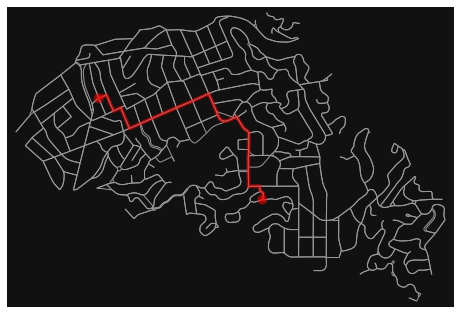

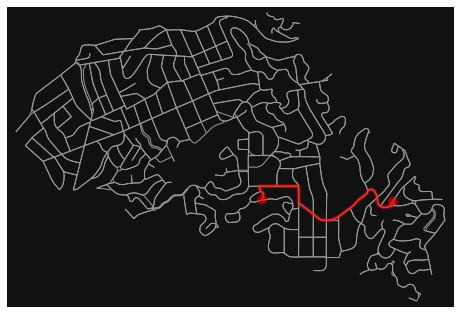

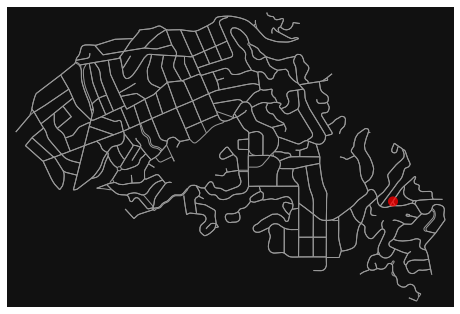

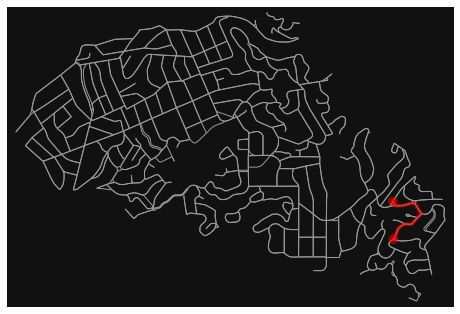

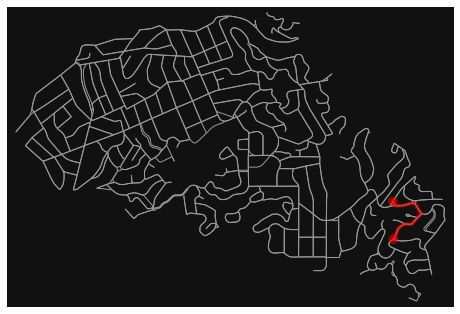

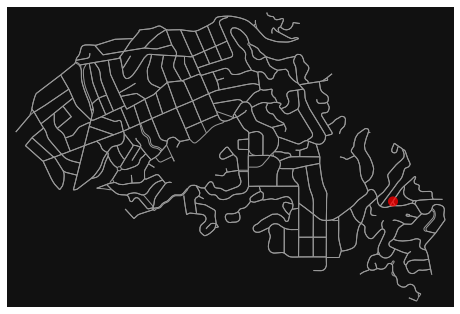

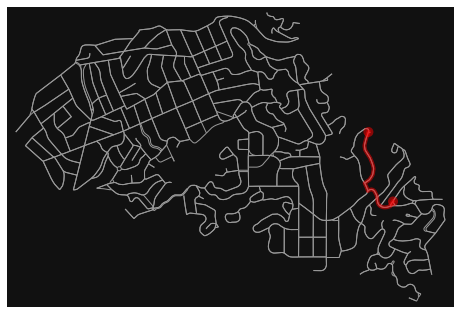

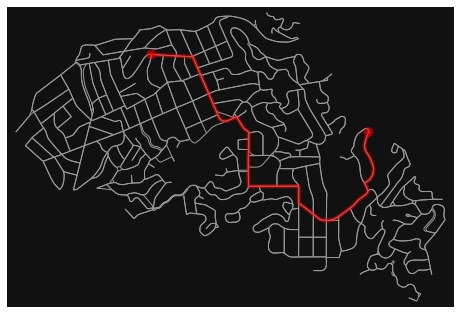

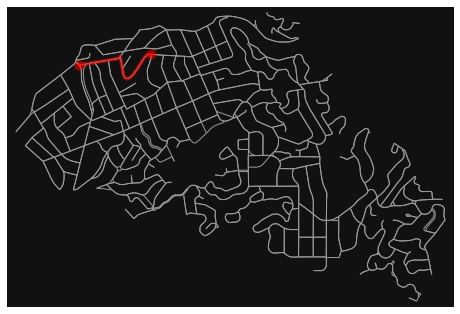

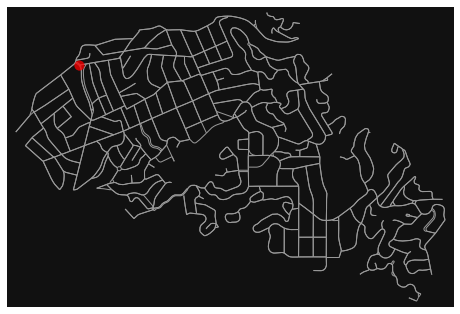

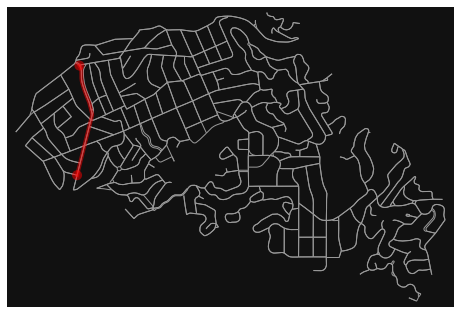

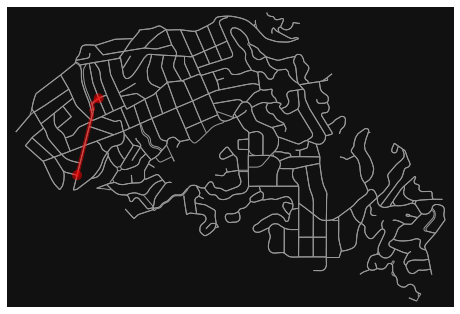

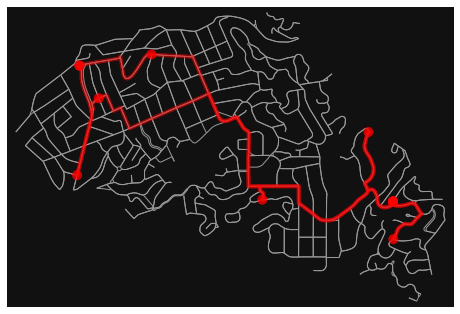

In [ ]:
display_shortest_route(origin, best_route)

In [ ]:
with open('file.pkl', 'wb') as file:
      
    pickle.dump(best_route, file)